In [40]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import math
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [41]:
start = dt.datetime.today()-dt.timedelta(10000)
end = dt.datetime.today()
#ticker = 'NVDA'
stock = yf.Ticker("NVDA")

In [47]:
#df = yf.download(ticker, start, end)
df = stock.history(period="max")
df.tail()
#df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-06-13,160.000000,163.119995,156.059998,156.470001,60415300.0,0.0,0.0
2022-06-14,157.309998,160.660004,154.119995,158.360001,46968000.0,0.0,0.0
2022-06-15,160.949997,168.679993,159.259995,165.270004,56393600.0,0.0,0.0
2022-06-16,158.600006,159.419998,154.009995,156.009995,54574900.0,0.0,0.0
2022-06-17,156.479996,159.949997,153.279999,158.800003,62905700.0,0.0,0.0


In [48]:
def psar(df, iaf = 0.02, maxaf = 0.2):
    length = len(df)
    dates = list(df.index)
    high = list(df['High'])
    low = list(df['Low'])
    close = list(df['Close'])
    psar = close[0:len(close)]
    psarbull = [None] * length # Bullish signal - dot below candle
    psarbear = [None] * length # Bearish signal - dot above candle
    bull = True
    af = iaf # acceleration factor
    ep = low[0] # ep = Extreme Point
    hp = high[0] # High Point
    lp = low[0] # Low Point

    # https://www.investopedia.com/terms/p/parabolicindicator.asp - Parabolic Stop & Reverse Formula from Investopedia 
    for i in range(2,length):
        if bull:
            psar[i] = psar[i - 1] + af * (hp - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (lp - psar[i - 1])
        reverse = False
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = hp
                lp = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = lp
                hp = high[i]
                af = iaf
        if not reverse:
            if bull:
                if high[i] > hp:
                    hp = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < lp:
                    lp = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
    return {"dates":dates, "high":high, "low":low, "close":close, "psar":psar, "psarbear":psarbear, "psarbull":psarbull}

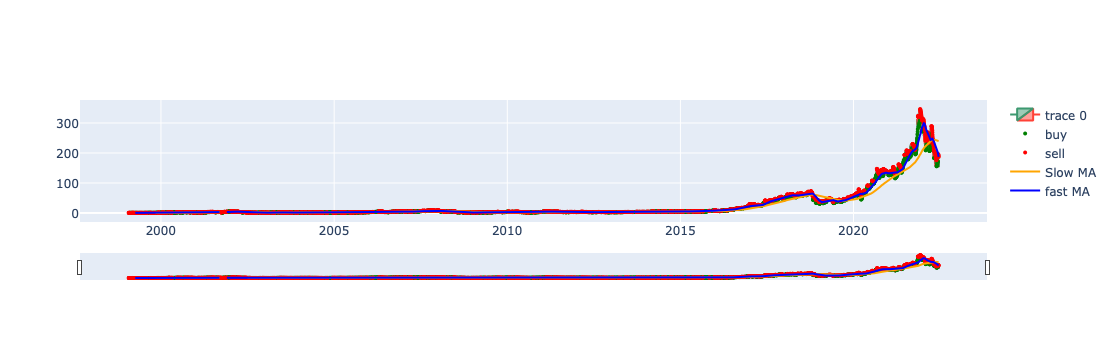

In [49]:
startidx = 0
endidx = len(df)

result = psar(df)
dates = result['dates'][startidx:endidx]
close = result['close'][startidx:endidx]
df["PSAR"] = result['psar'][startidx:endidx]
psarbear = result['psarbear'][startidx:endidx]
psarbull = result['psarbull'][startidx:endidx]
df['Slow MA'] = df['Close'].rolling(200).mean()
df['Fast MA'] = df['Close'].rolling(50).mean()

# plt.title('PSAR (Parabolic Stop & Reverse)')
# plt.plot(dates, close, label = ticker)
# plt.plot(dates, psarbull, label = 'Buy', color = 'green')
# plt.plot(dates, psarbear, label = 'Sell', color = 'red' )
# plt.plot(df['200 MA'], label = '200 Day MA')
# plt.legend()
# plt.grid()
# plt.show()

fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

fig.add_trace(go.Scatter(x=dates, y=psarbull, name='buy',mode = 'markers',
                         marker = dict(color='green', size=4)))

fig.add_trace(go.Scatter(x=dates, y=psarbear, name='sell', mode = 'markers',
                         marker = dict(color='red', size=4)))

fig.add_trace(go.Scatter(x=df.index, y=df['Slow MA'], name='Slow MA',
                         line = dict(color='orange', width=2)))

fig.add_trace(go.Scatter(x=df.index, y=df['Fast MA'], name='fast MA',
                          line = dict(color='Blue', width=2)))

#fig.show()

In [50]:
#import talib
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,PSAR,Slow MA,Fast MA
Date,,,,,,,,,,
2022-06-13,160.000000,163.119995,156.059998,156.470001,60415300.0,0.0,0.0,195.599362,240.948889,195.257052
2022-06-14,157.309998,160.660004,154.119995,158.360001,46968000.0,0.0,0.0,194.017788,240.609659,193.082981
2022-06-15,160.949997,168.679993,159.259995,165.270004,56393600.0,0.0,0.0,191.623920,240.302381,190.917538
2022-06-16,158.600006,159.419998,154.009995,156.009995,54574900.0,0.0,0.0,189.373685,239.963745,188.852634
2022-06-17,156.479996,159.949997,153.279999,158.800003,62905700.0,0.0,0.0,186.544590,239.636260,187.148266


In [51]:
#df['50 MA'], df['200 MA'] = talib.MA(df['Adj Close'], timeperiod=50, matype=0), talib.MA(df['Adj Close'], timeperiod=200, matype=0)
df['50 MA'] = df["Close"].rolling(50).mean()
df['200 MA'] = df["Close"].rolling(200).mean()
# df['9 MA'], df['21 MA'] = talib.MA(df['Adj Close'], timeperiod=9, matype=0), talib.MA(df['Adj Close'], timeperiod=21, matype=0)
#df['PSAR'] = real = talib.SAR(df['High'], df['Low'], acceleration=0.02, maximum=0.2)
# df['upperband'], df['middleband'], df['lowerband'] = talib.BBANDS(df['Adj Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df['Action'] = np.where(df['Close'] > df['200 MA'] , 1, 0) 
df['Action'] = np.where(df['Close'] < df['200 MA'], -1, df['Action'])
df['PSAR_Action'] = np.where(df['PSAR'] < df['Low'] , 1, 0) 
df['PSAR_Action'] = np.where(df['PSAR'] > df['High'], -1, df['PSAR_Action'])
df.dropna(inplace=True)
df.head(100)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,PSAR,Slow MA,Fast MA,50 MA,200 MA,Action,PSAR_Action
Date,,,,,,,,,,,,,,
1999-11-04,0.530869,0.572717,0.530869,0.558369,126033600.0,0.0,0.0,0.381270,0.392613,0.441088,0.441088,0.392613,1,1
1999-11-05,0.573912,0.578695,0.514130,0.540434,61636800.0,0.0,0.0,0.396586,0.393432,0.442475,0.442475,0.393432,1,1
1999-11-08,0.523695,0.571521,0.506956,0.555978,47001600.0,0.0,0.0,0.414797,0.394131,0.443646,0.443646,0.394131,1,1
1999-11-09,0.554782,0.557173,0.526087,0.547608,27235200.0,0.0,0.0,0.431187,0.394950,0.444686,0.444686,0.394950,1,1
1999-11-10,0.549401,0.549999,0.532065,0.542826,14404800.0,0.0,0.0,0.445937,0.395752,0.444782,0.444782,0.395752,1,1
1999-11-11,0.542826,0.609782,0.530869,0.581087,56270400.0,0.0,0.0,0.459213,0.396750,0.446145,0.446145,0.396750,1,1
1999-11-12,0.606195,0.612173,0.571521,0.612173,50150400.0,0.0,0.0,0.477282,0.397993,0.448250,0.448250,0.397993,1,1
1999-11-15,0.616358,0.634890,0.590651,0.600217,36220800.0,0.0,0.0,0.496166,0.399141,0.450043,0.450043,0.399141,1,1
1999-11-16,0.614565,0.669565,0.612174,0.657608,72379200.0,0.0,0.0,0.518362,0.400719,0.453032,0.453032,0.400719,1,1


In [52]:
def signal(df):
    if df['Action'] == 1 and df['PSAR_Action'] == 1:
        return 1
    elif df['Action'] == -1 and df['PSAR_Action'] == -1:
        return -1
    else:
        return 0

In [53]:
df['signal'] = df.apply(signal, axis = 1)
df.head(100)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,PSAR,Slow MA,Fast MA,50 MA,200 MA,Action,PSAR_Action,signal
Date,,,,,,,,,,,,,,,
1999-11-04,0.530869,0.572717,0.530869,0.558369,126033600.0,0.0,0.0,0.381270,0.392613,0.441088,0.441088,0.392613,1,1,1
1999-11-05,0.573912,0.578695,0.514130,0.540434,61636800.0,0.0,0.0,0.396586,0.393432,0.442475,0.442475,0.393432,1,1,1
1999-11-08,0.523695,0.571521,0.506956,0.555978,47001600.0,0.0,0.0,0.414797,0.394131,0.443646,0.443646,0.394131,1,1,1
1999-11-09,0.554782,0.557173,0.526087,0.547608,27235200.0,0.0,0.0,0.431187,0.394950,0.444686,0.444686,0.394950,1,1,1
1999-11-10,0.549401,0.549999,0.532065,0.542826,14404800.0,0.0,0.0,0.445937,0.395752,0.444782,0.444782,0.395752,1,1,1
1999-11-11,0.542826,0.609782,0.530869,0.581087,56270400.0,0.0,0.0,0.459213,0.396750,0.446145,0.446145,0.396750,1,1,1
1999-11-12,0.606195,0.612173,0.571521,0.612173,50150400.0,0.0,0.0,0.477282,0.397993,0.448250,0.448250,0.397993,1,1,1
1999-11-15,0.616358,0.634890,0.590651,0.600217,36220800.0,0.0,0.0,0.496166,0.399141,0.450043,0.450043,0.399141,1,1,1
1999-11-16,0.614565,0.669565,0.612174,0.657608,72379200.0,0.0,0.0,0.518362,0.400719,0.453032,0.453032,0.400719,1,1,1


In [20]:
pd.set_option("display.max_rows", 1000)
#df.tail(100)
# IF df.iloc[-1] == 0 THEN "Closing Position / Do Nothing"
# IF df.iloc[-1] == 1 THEN "BUY"
# IF df.iloc[-1] == -1 THEN "SELL / SHORT Sell"

In [ ]:
#fig1 = go.Figure(data=[go.Candlestick(x=df.index,
#                open=df['Open'],
#                high=df['High'],
#                low=df['Low'],
#                close=df['Close'])])

#fig1.add_trace(go.Scatter(x=dates, y=df['PSAR'], name='Parabolic Stop & Reverse (PSAR Signals)', mode = 'markers',
#                         marker = dict(color='black', size=4)))

#fig1.add_trace(go.Scatter(x=df.index, y=df['200 MA'], name='Slow MA',
#                         line = dict(color='orange', width=2)))

#fig1.add_trace(go.Scatter(x=df.index, y=df['50 MA'], name='fast MA',
#                         line = dict(color='Blue', width=2)))

#fig1.show()

In [54]:
# Create our features
#X = df['Adj Close', 'High', 'Low', ]

# Create our target
#y = df['loan_status']
#X.head()

In [56]:
df["signal"].iloc[-1]

-1

In [57]:
df.iloc[-1]

Open            1.564800e+02
High            1.599500e+02
Low             1.532800e+02
Close           1.588000e+02
Volume          6.290570e+07
Dividends       0.000000e+00
Stock Splits    0.000000e+00
PSAR            1.865446e+02
Slow MA         2.396363e+02
Fast MA         1.871483e+02
50 MA           1.871483e+02
200 MA          2.396363e+02
Action         -1.000000e+00
PSAR_Action    -1.000000e+00
signal         -1.000000e+00
Name: 2022-06-17 00:00:00, dtype: float64

In [60]:
type(df.iloc[-1])

pandas.core.series.Series

In [63]:
string_frame = df.iloc[-1].to_string()

In [64]:
type(string_frame)

str